### Load dataset from Kaggle

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
# .kaggle 디렉토리 생성 및 kaggle.json 파일 복사
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Change authorization of Kaggle Dataset API
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
%cd /content
!kaggle datasets download -d carlosrunner/pizza-not-pizza

/content
 93% 94.0M/101M [00:00<00:00, 237MB/s]
100% 101M/101M [00:00<00:00, 232MB/s] 


In [5]:
!unzip pizza-not-pizza.zip

Archive:  pizza-not-pizza.zip
  inflating: pizza_not_pizza/food101_subset.py  
  inflating: pizza_not_pizza/not_pizza/1005746.jpg  
  inflating: pizza_not_pizza/not_pizza/1009225.jpg  
  inflating: pizza_not_pizza/not_pizza/1012312.jpg  
  inflating: pizza_not_pizza/not_pizza/1018802.jpg  
  inflating: pizza_not_pizza/not_pizza/1020735.jpg  
  inflating: pizza_not_pizza/not_pizza/1027142.jpg  
  inflating: pizza_not_pizza/not_pizza/102839.jpg  
  inflating: pizza_not_pizza/not_pizza/1043233.jpg  
  inflating: pizza_not_pizza/not_pizza/1045400.jpg  
  inflating: pizza_not_pizza/not_pizza/104773.jpg  
  inflating: pizza_not_pizza/not_pizza/1050956.jpg  
  inflating: pizza_not_pizza/not_pizza/1054362.jpg  
  inflating: pizza_not_pizza/not_pizza/1062097.jpg  
  inflating: pizza_not_pizza/not_pizza/1066151.jpg  
  inflating: pizza_not_pizza/not_pizza/1070772.jpg  
  inflating: pizza_not_pizza/not_pizza/1070867.jpg  
  inflating: pizza_not_pizza/not_pizza/107499.jpg  
  inflating: pizza_not_

### Split Dataset

In [6]:
%pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
%cd /content

/content


In [8]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/pizza_not_pizza', output='/content/pizzaDataset',
                   seed=42, ratio=(.8, .1, .1))

Copying files: 1966 files [01:43, 19.02 files/s] 


In [9]:
%cd /content/drive/MyDrive/Colab Notebooks/ResNet

/content/drive/MyDrive/Colab Notebooks/ResNet


### main

In [10]:
from dataset import pizza_data_load, PizzaDataset
from model import *
from evaluate import evaluate 
from torchvision import transforms as T
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import time

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# 데이터셋 탐색

trainset = PizzaDataset('/content/pizzaDataset/', 'train')
valset = PizzaDataset('/content/pizzaDataset/', 'val')
testset = PizzaDataset('/content/pizzaDataset/', 'test')
print('Size of train set: ', len(trainset))
print('Size of val set: ', len(valset))
print('Size of test set: ', len(testset))
print()
print('Size of train not_pizza: ', len(trainset.not_pizza_files))
print('Size of train pizza: ', len(trainset.pizza_files))
print('Size of val not_pizza: ', len(valset.not_pizza_files))
print('Size of val pizza: ', len(valset.pizza_files))
print('Size of test not_pizza: ', len(testset.not_pizza_files))
print('Size of test pizza: ', len(testset.pizza_files))
print()
print(trainset.getfilename(0))

Size of train set:  1572
Size of val set:  196
Size of test set:  198

Size of train not_pizza:  786
Size of train pizza:  786
Size of val not_pizza:  98
Size of val pizza:  98
Size of test not_pizza:  99
Size of test pizza:  99

1183445.jpg


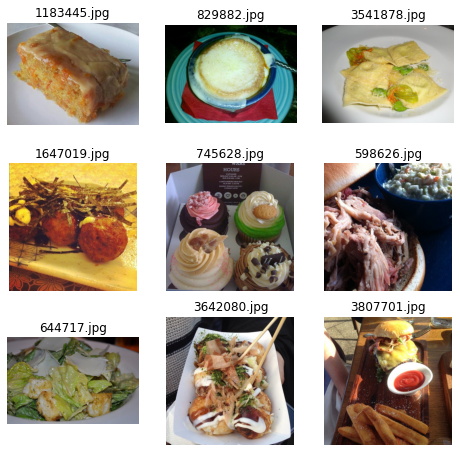

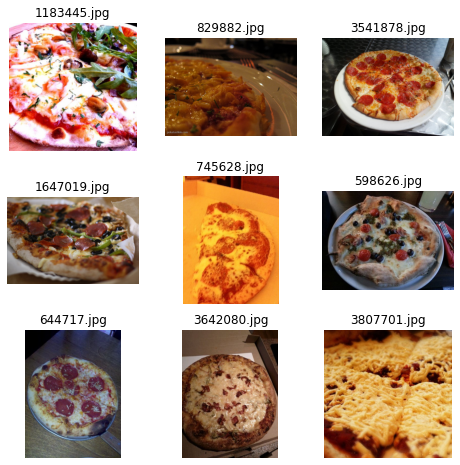

In [12]:
# get 9 images in each class
train_not_pizza_images = [trainset[i] for i in range(10)]
train_pizza_images = [trainset[i] for i in range(len(trainset.not_pizza_files),len(trainset.not_pizza_files)+10)]

def get_image(nrows, ncols, dataset):
    plt.figure(figsize=(8,8))
    for i in range(nrows*ncols):
        filename = trainset.getfilename(i)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(dataset[i][0])
        plt.title(filename)
        plt.axis('off')
    
    plt.show()

nrows, ncols = 3, 3
get_image(nrows, ncols, train_not_pizza_images)
get_image(nrows, ncols, train_pizza_images)

In [13]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

"""
torchvision builtin transforms

# shape transform
CenterCrop(size)
Resize(size)
RandomCrop(size, padding=None, pad_if_needed=False, fill=0)
RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.33))
RandomRotation(degrees)
Pad(padding, fill=0)

# spatial transform
ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
GaussianBlur(kernel_size, sigma=(0.1, 2.0))
RandomAffine(degrees, translate=None, scale=None, shear=None)
RandomGrayscale(p=0.1)
RandomHorizontalFlip(p=0.5)
RandomVerticalFlip(p=0.5)
RandomPerspective(distortion_scale=0.5, p=0.5)
RandomInvert(p=0.5)
RandomPosterize(bits, p=0.5)
RandomSolarize(threshold, p=0.5)
RandomAdjustSharpness(sharpness_factor, p=0.5)
RandomAutocontrast(p=0.5)

# auto-augment
AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET)

# others
RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
RandomApply(transforms, p=0.5)      # apply randomly a list of transformations with a given probability
"""
'''transform'''

'transform'

In [14]:
# Prepare to train
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32
train_loader, valid_loader, test_loader =\
    pizza_data_load(path='/content/pizzaDataset/',batch_size=batch_size,transforms=transform)

def resnet34(device):
    return ResNet(BasicBlock, [3, 4, 6, 3]).to(device)

model = resnet34(device)

summary(model, (3, 224, 224 ))


lr = 1e-4
EPOCHS = 30
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss().to(device)

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14         [-1

In [15]:
##### Train #####
print(device)

for epoch in tqdm(range(EPOCHS)):
    since = time.time()
    print("{}/{} Epochs".format(epoch + 1, EPOCHS))
    
    model.train()
    running_corrects, running_total = 0, 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        _, preds = torch.max(pred, 1)
        loss = loss_func(pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        # statistics
        running_total += y.size(0)
        running_corrects += (preds==y).sum().float()

    time_elapsed = time.time() - since
    epoch_acc = running_corrects.double() / running_total * 100

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print("Accuracy : ", epoch_acc)
    print("Loss     : ", loss.item())
    print('-' * 30)

cuda:0


  0%|          | 0/30 [00:00<?, ?it/s]

1/30 Epochs
Training complete in 1m 31s
Accuracy :  tensor(66.8575, device='cuda:0', dtype=torch.float64)
Loss     :  0.3222752809524536
------------------------------
2/30 Epochs
Training complete in 1m 32s
Accuracy :  tensor(72.3282, device='cuda:0', dtype=torch.float64)
Loss     :  0.08904356509447098
------------------------------
3/30 Epochs
Training complete in 1m 32s
Accuracy :  tensor(77.0992, device='cuda:0', dtype=torch.float64)
Loss     :  0.358712375164032
------------------------------
4/30 Epochs
Training complete in 1m 35s
Accuracy :  tensor(78.2443, device='cuda:0', dtype=torch.float64)
Loss     :  0.49477988481521606
------------------------------
5/30 Epochs
Training complete in 1m 35s
Accuracy :  tensor(81.2977, device='cuda:0', dtype=torch.float64)
Loss     :  0.3089524507522583
------------------------------
6/30 Epochs
Training complete in 1m 34s
Accuracy :  tensor(80.8524, device='cuda:0', dtype=torch.float64)
Loss     :  0.3027334213256836
----------------------

In [16]:
# Save parameter
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/ResNet/resnet34_2.pt")

In [31]:
# Load parameter
model = resnet34(device)

if device == torch.device('cuda:0'):
    print(device)
    model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/ResNet/resnet34.pt"))


cuda:0


In [17]:
# Eval for train/val set 

evaluate(model, train_loader, device, loss_func)
evaluate(model, valid_loader, device, loss_func)

Accuracy of Test Data: 92.04834747314453
Accuracy of Test Data: 86.2244873046875


In [18]:
# Evaluate

evaluate(model, test_loader, device, loss_func)

Accuracy of Test Data: 84.8484878540039
